#Data

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch 1/100
5000/5000 - 22s - loss: 0.0033 - val_loss: 0.0016
Epoch 2/100
5000/5000 - 21s - loss: 0.0011 - val_loss: 0.0113
Epoch 3/100
5000/5000 - 21s - loss: 8.0664e-04 - val_loss: 6.2269e-04
Epoch 4/100
5000/5000 - 21s - loss: 6.3956e-04 - val_loss: 2.9405e-04
Epoch 5/100
5000/5000 - 21s - loss: 5.0530e-04 - val_loss: 5.9208e-05
Epoch 6/100
5000/5000 - 21s - loss: 4.3624e-04 - val_loss: 0.0011
Epoch 7/100
5000/5000 - 21s - loss: 4.1129e-04 - val_loss: 8.5951e-05
Epoch 8/100
5000/5000 - 21s - loss: 4.0116e-04 - val_loss: 3.5357e-05
Epoch 9/100
5000/5000 - 21s - loss: 3.9413e-04 - val_loss: 1.3022e-05
Epoch 10/100
5000/5000 - 21s - loss: 3.8846e-04 - val_loss: 1.4833e-05
Epoch 11/100
5000/5000 - 21s - loss: 3.8560e-04 - val_loss: 3.6293e-05
Epoch 12/100
5000/5000 - 21s - loss: 3.8123e-04 - val_loss: 4.5200e-05
Epoch 13/100
5000/5000 - 21s - loss: 3.7979e-04 - val_loss: 1.1751e-05
Epoch 14/100
5000/5000 - 21s - loss: 3.7653e-04 - val_loss: 2.3745e-05
Epoch 15/100
5000/5000 - 21s - loss

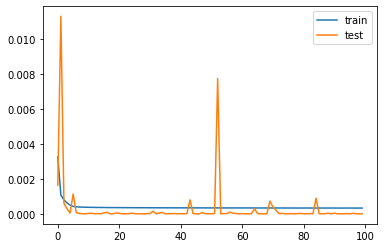

(98114, 2)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import string
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

#Reading the data
df = pd.read_csv("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv", sep=',', na_values=['nan', '?'], 
                 names=['ClassID', 'Title', 'Body'])
#Combining the text and body into a single dataframe caleld text 
df['Text'] = df['Title'].str.cat(df['Body'], sep =" ") 
df.drop(['Title', 'Body'], axis=1, inplace=True)

!python -m pip install pyspellchecker
!pip install num2words
!pip install word2vec
import nltk
nltk.download('stopwords')

from num2words import num2words 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
import operator
from spellchecker import SpellChecker

#Remove URLs
def remove_urls(data):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', data)

#Correcting spellings
def correct_spellings(data):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(data.split())
    for word in data.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def convert_lower_case(data):
  return str(data).lower()

#Removing the punctuations
def remove_punctuation(data):
  symbols = string.punctuation
  for symbol in symbols:
    data = str(data).replace(symbol, '')
  return data

#Remove single words a they are meaningless
def remove_single_characters(data):
  new_data = ""
  for word in data.split():
    if len(word) > 1:
      new_data = new_data + " " + word
  return new_data

#Convert numbers into words
def convert_numbers(data):
  new_data = ""
  for word in data.split():
    if(word.isnumeric()):
      word = num2words(word)
    new_data = new_data + " " + word
  return new_data

#Stemming the dataset
def stemming(data):
  stemmer = PorterStemmer()
  new_data = ""
  for word in data.split():
    word = stemmer.stem(word)
    new_data = new_data + " " + word
  return new_data

#Lemmatizing the dataset
def lemmatizer(data):
  lemmatizer = WordNetLemmatizer()
  new_data = ""
  for word in data.split():
    word = lemmatizer.lemmatize(word)
    new_data = new_data + " " + word
  return new_data

#Preprocessing-01
def preprocessing1(dataset):
  new_dataset = []
  for data in dataset:
    #data = remove_urls(data)
    #data = correct_spellings(data)
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_single_characters(data)
    data = convert_numbers(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    new_dataset.append(data)
  return new_dataset

df['Text'] = preprocessing1(df['Text'])
##################################################
#Preprocessing for removing stopwords

#Building a list of stopwords from the data using Zipf' Law
def buildstoplist(trainingdata):
    index = {}
    wordcount = 0
    wordprob = {}
    stop_words = list(stopwords.words('english')) #Calling predefined stopwords list from nltk
    for i in trainingdata:
        for word in i[0].split():
            word = re.sub('[^a-zA-Z0-9 \n\.]', '', word)
            if word != '':
                wordcount += 1
                if word not in index:
                    index[word] = 1
                else:
                    index[word] += 1
    
    for word in index:
        wordprob[word] = round(float(index[word])/wordcount*100,4) #Calculating the probability
        
    stoplist = sorted(wordprob, key=operator.itemgetter(1) ,reverse=True)[:25000] #Storing top 25000 most frequent words of the data
    
    for i in stoplist:
        stop_words.append(i[0]) #Making a list od stopwords
    stop_words.append('reuters')
    return stop_words
  
stopwords = buildstoplist(df['Text'])

#Removing stopwords from the dataset
def remove_stopwords(data):
  new_data = ""
  for word in data.split():
    if word not in stopwords:
      new_data = new_data + " " + word
  return new_data

#Preprocessing-02
def preprocessing2(dataset):
  new_dataset = []
  for data in dataset:
    #data = remove_urls(data)
    #data = correct_spellings(data)
    data = remove_stopwords(data)
    new_dataset.append(data)
  return new_dataset

df['Text'] = preprocessing2(df['Text'])
df['Text'].head()

from gensim.models import Word2Vec
sentences  = []
#Getting tokens of words
for sentence in df['Text']:
  sentences.append(sentence.split())

#Creating a word2vec with vector size of 150
model = Word2Vec(sentences, size = 150, min_count=1)
#Calling the vocabulary of model into X
X = model[model.wv.vocab]

# train autoencoder for classification with with compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler   
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
# number of input columns
n_inputs = X.shape[1]
# split into train test sets
X_train = X[:80000]
X_test = X[80000:]
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(2.0)
#float(n_inputs) / 5.0
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

import tensorflow as tf
encoder = tf.keras.models.load_model('encoder.h5') #calling the function
X = encoder.predict(X) #predicting the encoded X
X.shape

# Pivot Point Matrix(P):
This is a graph matrix of K Nearest Neighbors which act as the pivot points for the rest of the calculation for approximation of the matrix through Nystrom Method .This is created by the brute force method from the points sampled out from the large dataset. 

In [2]:
import random
from sklearn.neighbors import kneighbors_graph

idx = list(range(0, X.shape[0]))
rand_idx = random.sample(idx, 9400)
for i in rand_idx:
  idx.remove(i)

rand_X = []
for i in rand_idx:
  rand_X.append(X[i])

P = kneighbors_graph(rand_X, n_neighbors=5).toarray()

In [3]:
P. shape

(9400, 9400)

#Reference Point Matrix(R & R'):


In [ ]:
import numpy as np
from scipy.spatial import distance 

k = 9401
R = np.zeros((9400,88714))
R.shape

for i in rand_idx:
  for j in idx:
    if distance.euclidean(X[i], X[j]) < 5:
      R[i][k] = 1
    else:
      R[i][j] = 0
    k += 1

RT = numpy.transpose(R)

#Resultant Matrix(A):
Here we create the resultant matrix which would be used as the affinity matrix in the calculation of graph laplacian for eigen value decomposition.

In [ ]:
P_inv = np.linalg.inv(P)
A = RT* P_inv* R

#Diagnol Matrix(D):


In [ ]:
D = np.diag(A.sum(axis=1))

#Laplacian Matrix(L):

In [ ]:
# calculated the laplacian matrix by taking the difference between the diagnol matrix and the affinity matrix 
L = D-A

#Spectral Clustering:
Here we use the above created Laplacian matrix ..

In [ ]:
# find the eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# kmeans on first three vectors with nonzero eigenvalues
kmeans = KMeans(n_clusters=4)
kmeans.fit(vecs[:,1:4])
clusters = kmeans.labels_